### This file includes following configs(Model - Dimensionality reduction - Outlier detection):
- LSTM - PCA - Local Outlier
- LSTM - PCA - IsolationForest
- LSTM - AE - Local Outlier
- LSTM - AE - IsolationForest

# Importing and preparing data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from utils.load_data import custome_read_data
from joblib import dump, load

%matplotlib inline
tf.random.set_seed(42)

c:\Users\AssAssiN\Desktop\Work\9. Developing\AI Models\prototype\apatura\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading data

In [4]:
#fitted_scaler, fitted_outlier, fitted_pca, X_train_pca, y_train, X_test_pca, y_test = custome_read_data()
#fitted_scaler, fitted_outlier, X_train, y_train, X_test, y_test = custome_read_data()
X_train, y_train, X_test, y_test = custome_read_data(just_load=True)

In [5]:
X_train.shape

(373915, 23)

In [6]:
X_train_pca = X_train
X_test_pca = X_test

In [7]:
#encoder_file = "Final results and models/encoder_7.h5"
#encoder = tf.keras.models.load_model(encoder_file)

#X_train_pca = pd.DataFrame(encoder.predict(X_train))
#X_test_pca = pd.DataFrame(encoder.predict(X_test))

In [8]:
X_train_pca.shape

(373915, 23)

## Saving outlier model, PCA and scaler

In [9]:
#dump(fitted_outlier, "./results/IsolationForest.joblib")
#dump(fitted_scaler, "./results/Scaler.joblib")
#dump(fitted_pca, "./Final results and models/PCA_7.joblib")

## Function to creat slidig window format

In [10]:
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
from numpy import array
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

## Concate labels with data

In [11]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train_pca, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test_pca, y_test_array]

## You can change window size here

In [12]:
# Apply sequence transformation using time step of 25 for both train and test data
X_train_seq, y_train_seq = split_sequences(train_set, 50)
print(X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences(test_set, 50)
print(X_test_seq.shape, y_test_seq.shape)

(373866, 50, 23) (373866,)
(73819, 50, 23) (73819,)


# Modeling Data Preparation

Follow this ****[notebook](https://www.kaggle.com/gaurav2022/eda-dataviz-resample/)**** to see how I select time frame for model data preparation.

In [13]:
# Convert output variables to categorical for CNN
from tensorflow.keras.utils import to_categorical
y_train_seq = to_categorical(y_train_seq)
print(y_train_seq.shape)
print(y_train_seq)

y_test_seq = to_categorical(y_test_seq)
print(y_test_seq.shape)
print(y_test_seq)

(373866, 13)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(73819, 13)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train_seq.shape[1], X_train_seq.shape[2], y_train_seq.shape[1]
print(n_timesteps, n_features, n_outputs)

50 23 13


## Model1: CNN_LSTM

In [15]:
model = keras.Sequential()
model.add(layers.Input(shape=[50,23]))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.LSTM(64))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            2240      
                                                                 
 batch_normalization (BatchN  (None, 50, 32)           128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 50, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            6208      
                                                                 
 batch_normalization_1 (Batc  (None, 50, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 50, 64)            0

In [16]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Train Model1: CNN_LSTM

In [17]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
callbacks = [keras.callbacks.ModelCheckpoint("CNN_LSTM_50.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)]

#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)
model.compile(optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m], loss='categorical_crossentropy')

model_history = model.fit(X_train_seq, y_train_seq, epochs= 50, validation_data=(X_test_seq,y_test_seq), callbacks=callbacks)

Epoch 1/50
11684/11684 [==============================] - 117s 10ms/step - loss: 0.0024 - accuracy: 0.9994 - f1_m: 0.9995 - precision_m: 0.9995 - recall_m: 0.9994 - val_loss: 0.0029 - val_accuracy: 0.9997 - val_f1_m: 0.9997 - val_precision_m: 0.9997 - val_recall_m: 0.9997
Epoch 2/50
11684/11684 [==============================] - 113s 10ms/step - loss: 0.0021 - accuracy: 0.9995 - f1_m: 0.9995 - precision_m: 0.9995 - recall_m: 0.9995 - val_loss: 0.0034 - val_accuracy: 0.9997 - val_f1_m: 0.9997 - val_precision_m: 0.9997 - val_recall_m: 0.9997
Epoch 3/50
11684/11684 [==============================] - 114s 10ms/step - loss: 0.0016 - accuracy: 0.9995 - f1_m: 0.9995 - precision_m: 0.9995 - recall_m: 0.9995 - val_loss: 0.0083 - val_accuracy: 0.9995 - val_f1_m: 0.9995 - val_precision_m: 0.9995 - val_recall_m: 0.9995
Epoch 4/50
11684/11684 [==============================] - 114s 10ms/step - loss: 0.0020 - accuracy: 0.9996 - f1_m: 0.9996 - precision_m: 0.9996 - recall_m: 0.9995 - val_loss: 0.0102

## Ploting results of Model1

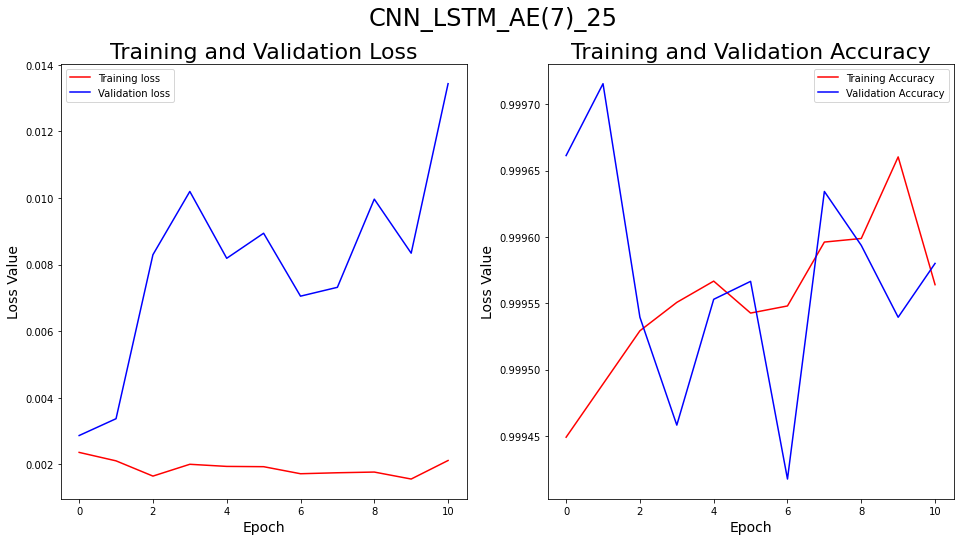

In [25]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(16, 8))

# Adding titles to subplots
ax[0].set_title('Training and Validation Loss',  fontsize=22)
ax[0].plot(train_loss, 'r', label='Training loss')
ax[0].plot(val_loss, 'b', label='Validation loss')

ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Loss Value', fontsize=14)
ax[0].legend()

ax[1].set_title('Training and Validation Accuracy',  fontsize=22)
ax[1].plot(train_accuracy, 'r', label='Training Accuracy')
ax[1].plot(val_accuracy, 'b', label='Validation Accuracy')

ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Loss Value', fontsize=14)
ax[1].legend()

# Adding a title to the figure
fig.suptitle('CNN_LSTM_AE(7)_25', fontsize=24)

#fig.tight_layout()
plt.savefig('CNN_LSTM_AE(7)_25.jpeg', dpi=400)
plt.show()

## Evaluation on Test and Train data

In [22]:
""" 
#model = keras.models.load_model('./CNN_LSTM.h5')
train_loss, train_acc = model.evaluate(X_train_seq,y_train_seq)
test_loss, test_acc = model.evaluate(X_test_seq,y_test_seq)

print("Train accuracy", round(train_acc*100, 2),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 2),'%')
print("Test loss", test_loss)

pred = model.predict(X_test_seq)
pred = np.argmax(pred, axis = 1)
pred = pred.reshape(-1,1)
"""

' \n#model = keras.models.load_model(\'./CNN_LSTM.h5\')\ntrain_loss, train_acc = model.evaluate(X_train_seq,y_train_seq)\ntest_loss, test_acc = model.evaluate(X_test_seq,y_test_seq)\n\nprint("Train accuracy", round(train_acc*100, 2),\'%\')\nprint("Train loss", train_loss)\nprint("Test accuracy", round(test_acc*100, 2),\'%\')\nprint("Test loss", test_loss)\n\npred = model.predict(X_test_seq)\npred = np.argmax(pred, axis = 1)\npred = pred.reshape(-1,1)\n'

## Converting Model1 to tflite

In [1]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)


converter.target_spec.supported_ops = [
 tf.lite.Optimize.DEFAULT,
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_quant_model = converter.convert()

NameError: name 'tf' is not defined

In [ ]:
with open('model_CNN_LSTM_50.tflite', 'wb') as f:
  f.write(tflite_quant_model)

## To Do: Testing other models including CNN, LSTM, FFNN

In [ ]:
"""
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
import tensorflow as tf
from tensorflow import keras
# Sequential model type
model = Sequential()
# 2 1D CNN layers for learning features from the time series samples
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(25,16), padding='same'))
model.add(Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
model.add(Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
# Pooling layer - reduces learned feature sizes to most essential elements
model.add(MaxPooling1D(pool_size=2))
# Flvatten learned features to ector
model.add(Flatten())
# Fully connected dense layer - interpret features
model.add(Dense(128, activation='relu'))
# Output layer using softmax
model.add(Dense(13, activation='softmax'))
model.summary()
"""

In [ ]:
"""
model = keras.Sequential()
model.add(layers.Input(shape=[25,16]))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))
model.summary()
"""